In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")
%matplotlib inline


In [2]:
# 2

df = pd.read_csv("../data/kc_house_data_encoded_linear_step3.csv")

print("Shape:", df.shape)
df.head()


Shape: (21613, 96)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,agebin_50–100 yrs,agebin_<20 yrs,agebin_>100 yrs
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,False,False,False,True,False,False,False,True,False,False
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,False,False,False,False,False,False,False,True,False,False
2,2,1.00,770,10000,1.0,0,0,3,6,770,...,False,False,False,False,False,False,False,True,False,False
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,False,False,False,False,False,False,False,False,False,False
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# 3

object_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("Object columns:", object_cols)


Object columns: []


In [4]:
# 4. Define features X and target y (log_price)

target_col = "log_price"
X = df.drop(columns=[target_col])
y = df[target_col].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (21613, 95)
y shape: (21613,)


In [5]:
# 5 Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (17290, 95)
X_test shape: (4323, 95)
y_train shape: (17290,)
y_test shape: (4323,)


In [6]:
# 6 Build pipeline: StandardScaler + LinearRegression


lin_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_reg.fit(X_train, y_train)
print("Training complete.")


Training complete.


In [7]:
# 7 Model fitting

def print_metrics(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {label} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R^2 : {r2:.4f}\n")


In [8]:
# 8 Evaluate on train & test (in log space)

y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

print_metrics(y_train, y_train_pred, "Train (log_price)")
print_metrics(y_test, y_test_pred, "Test  (log_price)")


--- Train (log_price) ---
RMSE: 0.1805
MAE : 0.1327
R^2 : 0.8817

--- Test  (log_price) ---
RMSE: 0.1854
MAE : 0.1351
R^2 : 0.8794



In [9]:
# 9 Convert back to price

y_train_price = np.exp(y_train)
y_train_pred_price = np.exp(y_train_pred)

y_test_price = np.exp(y_test)
y_test_pred_price = np.exp(y_test_pred)

print_metrics(y_train_price, y_train_pred_price, "Train (price)")
print_metrics(y_test_price, y_test_pred_price, "Test  (price)")


--- Train (price) ---
RMSE: 145381.0134
MAE : 73831.9464
R^2 : 0.8382

--- Test  (price) ---
RMSE: 193507.3186
MAE : 79568.6181
R^2 : 0.7523



In [10]:
# 10 5-Fold Cross Validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse = -cross_val_score(lin_reg, X, y, cv=kf, scoring="neg_root_mean_squared_error")
cv_mae  = -cross_val_score(lin_reg, X, y, cv=kf, scoring="neg_mean_absolute_error")
cv_r2   =  cross_val_score(lin_reg, X, y, cv=kf, scoring="r2")

print("=== 5-FOLD CROSS VALIDATION RESULTS ===")
print(f"RMSE: mean={cv_rmse.mean():.4f}, std={cv_rmse.std():.4f}")
print(f"MAE : mean={cv_mae.mean():.4f}, std={cv_mae.std():.4f}")
print(f"R^2 : mean={cv_r2.mean():.4f}, std={cv_r2.std():.4f}")


=== 5-FOLD CROSS VALIDATION RESULTS ===
RMSE: mean=0.1828, std=0.0018
MAE : mean=0.1338, std=0.0010
R^2 : mean=0.8795, std=0.0029


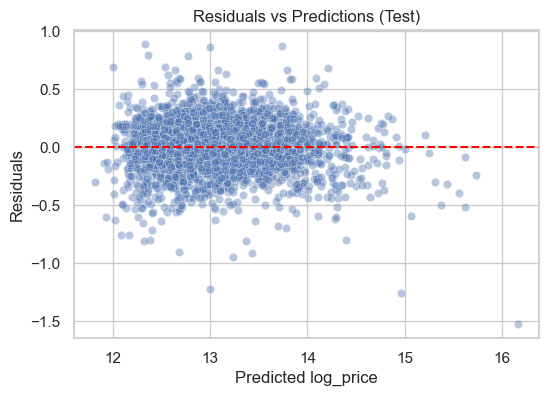

In [11]:
# 11 Residual Plot

residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted log_price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions (Test)")
plt.show()


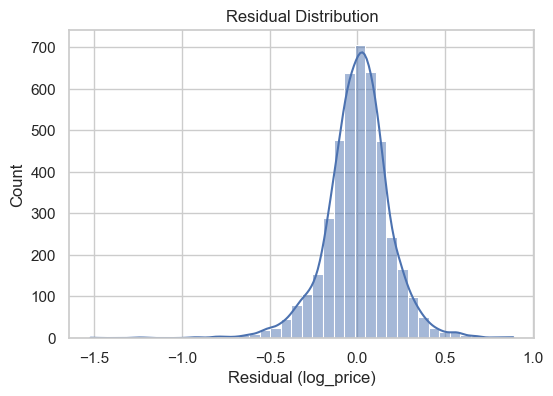

In [12]:
# 12 Residual distribution

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (log_price)")
plt.show()


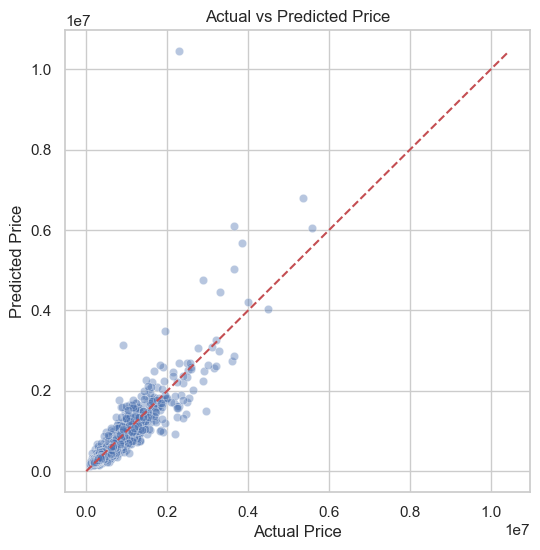

In [13]:
# 13 Actual vs Predicted Price

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_price, y=y_test_pred_price, alpha=0.4)
max_val = max(y_test_price.max(), y_test_pred_price.max())
plt.plot([0, max_val], [0, max_val], "r--")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()


In [14]:
# 14 Feature Coefficients

scaler = lin_reg.named_steps["scaler"]
model  = lin_reg.named_steps["model"]

coefs = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_
}).sort_values(by="coefficient", ascending=False)

coefs.head(20)


,feature,coefficient
16,sale_year,0.177712
25,zip_98004,0.112079
8,grade,0.106814
9,sqft_above,0.100901
64,zip_98103,0.095916
71,zip_98115,0.095214
70,zip_98112,0.094203
73,zip_98117,0.086731
43,zip_98033,0.085489
2,sqft_living,0.082016


In [15]:
# lowest coefficients

coefs.tail(20)


,feature,coefficient
40,zip_98030,0.004648
88,zip_98178,0.004476
15,sqft_lot15,0.004376
83,zip_98148,0.002896
93,agebin_<20 yrs,0.001767
0,bedrooms,0.001696
89,zip_98188,-0.000349
23,zip_98002,-0.000728
90,zip_98198,-0.001772
24,zip_98003,-0.001969


In [16]:
imputer = SimpleImputer(strategy="median")

ridge = Pipeline([
    ("imputer", imputer),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

ridge.fit(X_train, y_train)
print_metrics(y_test, ridge.predict(X_test), "Ridge")

lasso = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # separate instance is fine too
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.01, random_state=42, max_iter=10000))
])

lasso.fit(X_train, y_train)
print_metrics(y_test, lasso.predict(X_test), "Lasso")


--- Ridge ---
RMSE: 0.1853
MAE : 0.1350
R^2 : 0.8795

--- Lasso ---
RMSE: 0.2036
MAE : 0.1519
R^2 : 0.8546

